In [10]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import torch
import torch.optim as optim
# import wandb
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel
from torch.nn.utils.rnn import pad_sequence

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# read labels and text corresponding to images
train = pd.read_json("/content/drive/MyDrive/DL/DL Assignments/A4/hateful_memes/train.jsonl",lines=True)
test = pd.read_json("/content/drive/MyDrive/DL/DL Assignments/A4/hateful_memes/dev_seen.jsonl",lines=True)
val = pd.read_json("/content/drive/MyDrive/DL/DL Assignments/A4/hateful_memes/test_seen.jsonl",lines=True)

In [14]:
train.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


<Axes: >

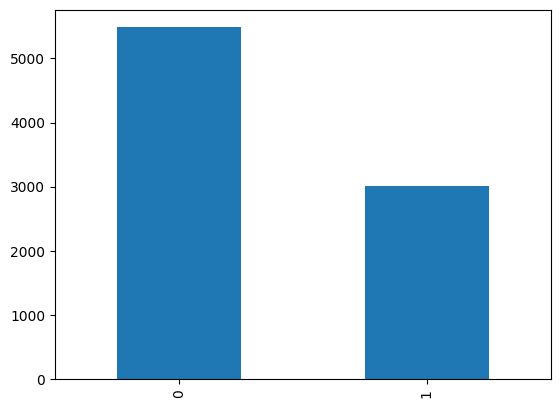

In [15]:
# plot of label count
train["label"].value_counts().plot(kind="bar")

In [16]:
# load pre trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [17]:
# function to return text tokens
def preprocess_text(text):
    tokens = tokenizer.tokenize(text) # Tokenize the text
    token_ids = tokenizer.convert_tokens_to_ids(tokens) # Convert tokens to IDs
    return token_ids

In [18]:
# apply tokenize to all
train['text_tokens'] = train['text'].apply(preprocess_text)
val['text_tokens'] = val['text'].apply(preprocess_text)
test['text_tokens'] = test['text'].apply(preprocess_text)

In [19]:
# class for BERT
class BertClassificationModel(torch.nn.Module):
    def __init__(self):
        super(BertClassificationModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = torch.nn.Dropout(0.5)
        self.linear = torch.nn.Linear(768, 2)
        
    # define forward method
    def forward(self, input_ids):
        output = self.bert(input_ids=input_ids)
        pooled_output = output.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.linear(pooled_output)
        return logits

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
# to tensor
train_tokens = [torch.tensor(token) for token in train['text_tokens']]
train_tokens = pad_sequence(train_tokens, batch_first=True, padding_value=0)

In [22]:
# to tensor
val_tokens = [torch.tensor(token) for token in val['text_tokens']]
val_tokens = pad_sequence(val_tokens, batch_first=True, padding_value=0)

In [23]:
# to tensor
test_tokens = [torch.tensor(token) for token in test['text_tokens']]
test_tokens = pad_sequence(test_tokens, batch_first=True, padding_value=0)

In [24]:
# to tensor
train_labels = torch.tensor([i for i in train['label']])
val_labels = torch.tensor([i for i in val['label']])
test_labels = torch.tensor([i for i in test['label']])

In [25]:
batch_size=32
# define data loaders
train_dataset = torch.utils.data.TensorDataset(train_tokens, train_labels)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [26]:
val_dataset = torch.utils.data.TensorDataset(val_tokens, val_labels)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [27]:
test_dataset = torch.utils.data.TensorDataset(test_tokens, test_labels)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [28]:
model = BertClassificationModel()
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertClassificationModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [ ]:
# hyper-parameters
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [ ]:
tloss=[]
vloss=[]
taccuracy=[]
vaccuracy=[]

# define train loop
for epoch in range(10):
    model.train()
    train_loss,train_accuracy = 0,0
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs, labels = batch
        optimizer.zero_grad()
        logits = model(inputs)
        loss_func = torch.nn.CrossEntropyLoss()
        loss = loss_func(logits.view(-1, 2), labels.view(-1))
        loss.backward()
        optimizer.step()
        pred_t = np.argmax(logits.detach().cpu().numpy(), axis=1)
        train_accuracy += accuracy_score(labels.detach().cpu().numpy(), pred_t)
        train_loss += loss.item()
    scheduler.step()
    train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_accuracy / len(train_dataloader)
    model.eval()
    val_loss, val_accuracy = 0, 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = tuple(t.to(device) for t in batch)
            inputs, labels = batch
            logits = model(inputs)
            loss_func = torch.nn.CrossEntropyLoss()
            loss = loss_func(logits.view(-1, 2), labels.view(-1))
            val_loss += loss.item()
            preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
            val_accuracy += accuracy_score(labels.detach().cpu().numpy(), preds)
    val_loss = val_loss / len(val_dataloader)
    val_accuracy = val_accuracy / len(val_dataloader)
    train_accuracy=train_accuracy*100
    val_accuracy=val_accuracy*100
    taccuracy.append(train_accuracy)
    vaccuracy.append(val_accuracy)
    tloss.append(train_loss)
    vloss.append(val_loss)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch 1, Train Loss: 0.6213, Val Loss: 0.7272, Val Accuracy: 59.7656
Epoch 2, Train Loss: 0.5108, Val Loss: 0.7142, Val Accuracy: 60.2539
Epoch 3, Train Loss: 0.4415, Val Loss: 0.8957, Val Accuracy: 56.1523
Epoch 4, Train Loss: 0.3824, Val Loss: 0.8466, Val Accuracy: 59.6680
Epoch 5, Train Loss: 0.3281, Val Loss: 0.9916, Val Accuracy: 57.5195
Epoch 6, Train Loss: 0.2833, Val Loss: 1.0976, Val Accuracy: 58.8867
Epoch 7, Train Loss: 0.2513, Val Loss: 1.4265, Val Accuracy: 58.6914
Epoch 8, Train Loss: 0.2276, Val Loss: 1.5320, Val Accuracy: 59.0820
Epoch 9, Train Loss: 0.2114, Val Loss: 1.6766, Val Accuracy: 57.7148
Epoch 10, Train Loss: 0.1979, Val Loss: 1.7828, Val Accuracy: 59.8633


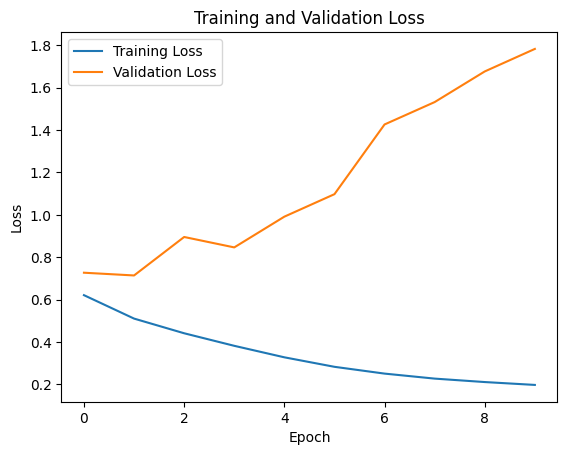

In [ ]:
# Plot the training and validation loss
plt.plot(tloss, label='Training Loss')
plt.plot(vloss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

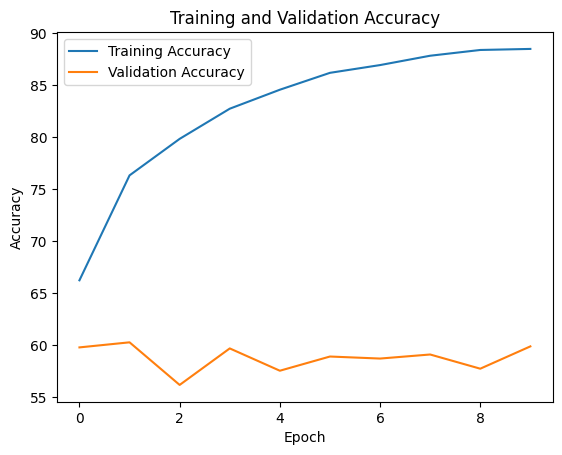

In [ ]:
# Plot the training and validation loss
plt.plot(taccuracy, label='Training Accuracy')
plt.plot(vaccuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# save model
torch.save(model.state_dict(), 'text_classifier.pt')

In [ ]:
model.load_state_dict(torch.load('text_classifier.pt'))

<All keys matched successfully>

In [ ]:
# measure test accurancy
correct = 0
total = 0
with torch.no_grad():
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs, labels = batch
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy :- {100 * correct // total} %')

Test Accuracy :- 55 %


In [ ]:
# Initialize lists to store labels and predictions
targets = []
predictions = []

# Iterate over test set and make predictions
with torch.no_grad():
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs, labels = batch
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        targets += labels.tolist()
        predictions += preds.tolist()

# Calculate overall precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(targets, predictions, average='macro')

print(f'Overall Precision: {precision:.4f}')
print(f'Overall Recall: {recall:.4f}')
print(f'Overall F1 Score: {f1_score:.4f}')

# Calculate class-wise precision, recall, and F1 score
precision, recall, f1_score, support = precision_recall_fscore_support(targets, predictions)

for i in range(2):
    print(f'Class {i} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1 Score: {f1_score[i]:.4f}')

Overall Precision: 0.5687
Overall Recall: 0.5554
Overall F1 Score: 0.5342
Class 0 - Precision: 0.5444, Recall: 0.7747, F1 Score: 0.6395
Class 1 - Precision: 0.5929, Recall: 0.3360, F1 Score: 0.4289


In [1]:
import pickle
with open('parrot.pkl', 'rb') as f:
  compare_labels = pickle.load(f)

In [30]:
compare_labels['text_tokens'] = compare_labels['text'].apply(preprocess_text)

In [31]:
compare_labels_tokens = [torch.tensor(token) for token in compare_labels['text_tokens']]
compare_labels_tokens = pad_sequence(compare_labels_tokens, batch_first=True, padding_value=0)
compare_labels_labels = torch.tensor([i for i in compare_labels['label']])
compare_labels_dataset = torch.utils.data.TensorDataset(compare_labels_tokens, compare_labels_labels)
compare_labels_dataloader = torch.utils.data.DataLoader(compare_labels_dataset, batch_size=200, shuffle=True)

In [37]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
   
    ## -- do not need to change the code below this line -- ##
    features = []
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        for i,j in layer._modules.items():
          # print([i],'ppp',j,'ss')
          if i == 'pooler':
            x = j(x[0])
            features.append(x)
          else:
            x = j(x)
          
        
                  
    return features
f= []
l = []
for i,j in compare_labels_dataloader:
    f.append(get_features(i,model))
    l.append(j)
    

In [39]:
state_dict = torch.load("/content/drive/MyDrive/DL/DL Assignments/A4/Q2/text_classifier.pt",map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

<All keys matched successfully>

100 100 100


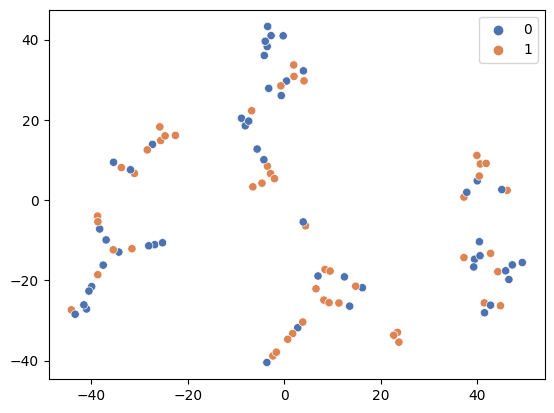

In [40]:
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.feature_extraction import get_graph_node_names
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',init='pca', perplexity=3).fit_transform(f[0][0].detach().numpy())
x1= []
y1 = []
for i in X_embedded:
  x1.append(i[0])
  y1.append(i[1])
print(len(j),len(x1),len(y1))
sns.scatterplot(x=x1,y=y1,hue=l[0],palette="deep")     
cmap = ListedColormap(sns.color_palette("deep", 256).as_hex())

